In [1]:
import os ; import sys
sys.path.append(os.environ["DMRGROOT"]) # add the library via environmental variable
# you have to install the dmrgpy library from
# https://github.com/joselado/dmrgpy
# and add its address to your python path (done above with an environmental variable)

# some default parameters in matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['font.size'] = 22
plt.rcParams['image.cmap'] = 'coolwarm'


import numpy as np

# Quantum interacting fermionic models

### Contents

### Learning outcomes
- Understand the structure of a quantum many-body fermionic Hamiltonian
- Rationalize level crossing in many-body fermionic systems
- Understand the meaning of static correlators in fermionic many-body systems



## Basics
Here you can learn the basics of the code that you will use

### Creating a fermion_chain object
This is the most important object, it is an abstract object that contains your physical system and will allow you to compute all the quantities

In [3]:
from dmrgpy import fermionchain
fc = fermionchain.Fermionic_Chain(6) # create the fermion chain object
fc = fermionchain.Spinful_Fermionic_Chain(6) # or with spinful fermions

### Creating a Hamiltonian
You can write a many-body Hamiltonian directly with the many-body spin operators

In [3]:
from dmrgpy import fermionchain
fc = fermionchain.Fermionic_Chain(2) # create the fermion chain object
H_K = fc.Cdag[0]*fc.Cdag[1] # this would be a hopping
H_K = H_K + H_K.get_dagger() # you can add the Hermitian part like this
H_V = fc.N[0]*fc.N[1] # density-density, equivalent to fc.Cdag[0]*fc.Cdag[0]*fc.Cdag[1]*fc.Cdag[1]

### Computing the ground state energy
Once you have computed a Hamiltonian, you can obtain the ground state energy by setting the Hamiltonian in the spin chain object and executing a bound method 

In [4]:
fc.set_hamiltonian(H_K + 1*H_V) # set the Hamiltonian
print("Energy of the model",fc.gs_energy(mode="ED"))

Energy of the model -0.6180339887498948


#### Quiz
- Remove the interaction, do you understand why that is the ground state energy? 

### Computing expectation values
Apart from the ground state energy, we may want to compute observables associated to ground state. This can be done either by using the built in algebra and compute overlaps, or by a bound method

In [5]:
from dmrgpy import fermionchain
L = 4 # number of fermionic sites
fc = fermionchain.Fermionic_Chain(L) # create the fermion chain object
H = 0 # initialize Hamiltonian
for i in range(L-1): # nearest neighbor hopping
    H = H + fc.Cdag[i]*fc.C[i+1] # add hopping
H = H + H.get_dagger() # Hermitian conjugate
V = 0.5 # interaction
for i in range(L-1): # nearest neighbor interaction
    H = H + V*fc.N[i]*fc.N[i+1] # add interaction

fc.set_hamiltonian(H) # set the Hamiltonian
GS = fc.get_gs() # compute the ground state

Op = fc.Cdag[0]*fc.C[1] # correlator between first and second sites

wOw0 = GS.dot(Op*GS).real # compute the expectation value with the braket < GS | Op | GS >
wOw1 = fc.vev(Op).real # compute the expectation value with the built in method

print("Correlator with the braket",wOw0)
print("Correlator with the built in method",wOw1)

Correlator with the braket -0.4536583427238179
Correlator with the built in method -0.45365834272381766


### Quiz
- Replace Cdag by C in the operator to compute the expectation value (Op). What happens, and why?
- Compute the number of fermions in each site using the operators C and Cdag

## Many-body energies of an interacting fermionic model
Let us first look at the many-body spectrum of a Heisenberg model

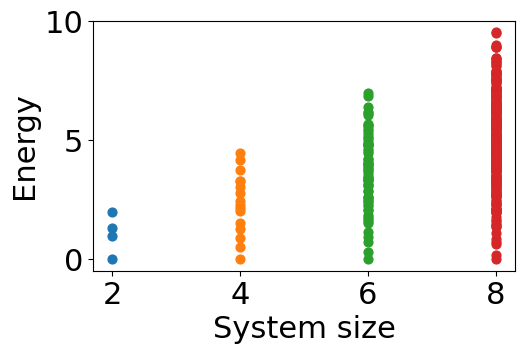

In [6]:


def get_energies(L):
    """Return energies for a system fo size L"""
    fc = fermionchain.Fermionic_Chain(L) # create the fermion chain object
    H = 0 # initialize Hamiltonian
    for i in range(L-1): # nearest neighbor hopping
        H = H + fc.Cdag[i]*fc.C[i+1] # add hopping
    H = H + H.get_dagger() # Hermitian conjugate
    V = 0.3 # interaction
    for i in range(L-1): # nearest neighbor interaction
        H = H + V*fc.N[i]*fc.N[i+1] # add interaction
    fc.set_hamiltonian(H) # set the Hamiltonian
    return fc.get_excited(mode="ED",n=300)

plt.figure(figsize=(6,4))

for N in [2,4,6,8]: # loop over system sizes
    es = get_energies(N) # many-body energies for a system of size N
    es = es-es[0] # set reference in the ground state
    plt.scatter(es*0 + N,es,s=40) # plot the energies

plt.xlabel("System size") ; plt.ylabel("Energy") ;  plt.tight_layout()

### Quiz
- Why is the number of energies increasing with the system size
- How does the number of energies depend on the system size
- Plot only the difference between the two lowest states, what do you observe?
- What is the biggest system for which you could store all the energies in your computer?

## Towards interaction-induced symmetry breaking
Let us see how interactions promote a phase transition

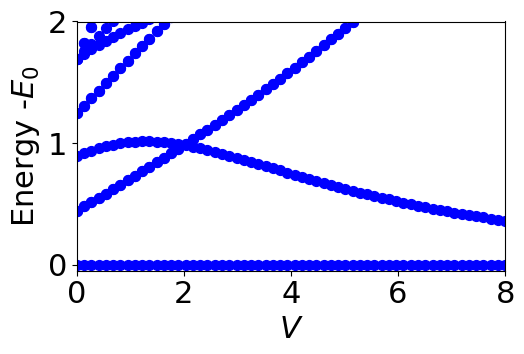

In [8]:
from dmrgpy import spinchain

def get_energies(V):
    """Return excitation energies"""
    L = 6
    fc = fermionchain.Fermionic_Chain(L) # create the fermion chain object
    H = 0 # initialize Hamiltonian
    for i in range(L-1): # nearest neighbor hopping
        H = H + fc.Cdag[i]*fc.C[i+1] # add hopping
    H = H + H.get_dagger() # Hermitian conjugate
    for i in range(L-1): # nearest neighbor interaction
        H = H + V*(fc.N[i]-0.5)*(fc.N[i+1]-0.5) # add interaction
    fc.set_hamiltonian(H) # set the Hamiltonian
    return fc.get_excited(mode="ED",n=10)

Vs = np.linspace(0.,8.,60)

plt.figure(figsize=(6,4))

for V in Vs: # loop over magnetic fields
    es = get_energies(V) # many-body energies for a system of size N
    es = es -es[0]# set reference in the ground state
    plt.scatter(es*0 + V,es,s=50,c="blue") # plot the energies

plt.xlabel("$V$") ; plt.ylabel("Energy -$E_0$") ; plt.xlim([min(Vs),max(Vs)]) 
plt.ylim([-0.05,2]) ; plt.tight_layout()

### Quiz
- Where could there be a phase transition?
- If you make the system bigger (L=14), what happens?
- Which side may be metallic, and which side may be insulating?

## Energies of an interacting fermionic model as a function of the chemical potential
We will now look at the evolution of the energies as a function of the chemical potential

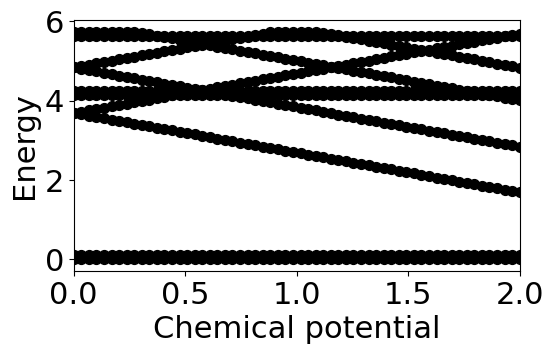

In [9]:

def get_energies(mu):
    """Return excitation energies"""
    L = 8
    fc = fermionchain.Fermionic_Chain(L) # create the fermion chain object
    H = 0 # initialize Hamiltonian
    for i in range(L-1): # nearest neighbor hopping
        H = H + fc.Cdag[i]*fc.C[i+1] # add hopping
    H = H + H.get_dagger() # Hermitian conjugate
    V = 10.0 # interaction
    for i in range(L-1): # nearest neighbor interaction
        H = H + V*(fc.N[i]-0.5)*(fc.N[i+1]-0.5) # add interaction
    for i in range(L): H = H + mu*fc.N[i] # chemical potential
    fc.set_hamiltonian(H) # set the Hamiltonian
    return fc.get_excited(mode="ED",n=10)

mus = np.linspace(0.,2.,60)

plt.figure(figsize=(6,4))

for mu in mus: # loop over magnetic fields
    es = get_energies(mu) # many-body energies for a system of size N
    es = es -es[0] # set reference in the ground state
    plt.scatter(es*0 + mu,es,s=50,c="black") # plot the energies

plt.xlabel("Chemical potential") ; plt.ylabel("Energy") ; plt.xlim([min(mus),max(mus)]) ; plt.tight_layout()

### Quiz
- Why do the eigenvalues evolve linearly with the chemical potential?
- What are the states above the ground state in terms of excitations?

## Quantum numbers in the interacting fermionic model
We will now see how in the Heisenebrg model the quantum number conservation can be directly seen from the spectra

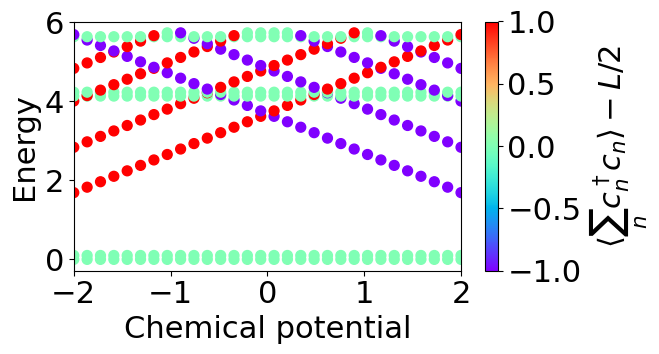

In [10]:
from dmrgpy import spinchain

def get_energies_den(mu):
    """Return excitation energies"""
    L = 8
    fc = fermionchain.Fermionic_Chain(L) # create the fermion chain object
    H = 0 # initialize Hamiltonian
    for i in range(L-1): # nearest neighbor hopping
        H = H + fc.Cdag[i]*fc.C[i+1] # add hopping
#    for i in range(L-2): H = H + 0.6*fc.Cdag[i]*fc.C[i+2] # second neighbor hopping
    H = H + H.get_dagger() # Hermitian conjugate
    V = 10.0 # interaction
    for i in range(L-1): # nearest neighbor interaction
        H = H + V*(fc.N[i]-0.5)*(fc.N[i+1]-0.5) # add interaction
    for i in range(L): H = H + mu*fc.N[i] # chemical potential
    fc.set_hamiltonian(H) # set the Hamiltonian
    es,wfs = fc.get_excited_states(mode="ED",n=10)
    cs = [wf.dot(sum(fc.N)*wf) for wf in wfs] # expectation values
    return es-es[0],np.array(cs) - L/2.

mus = np.linspace(-2.,2.,30)

plt.figure(figsize=(7,4))

for mu in mus: # loop over chemical potentials
    es,cs = get_energies_den(mu) # many-body energies for a system of size N
    plt.scatter(es*0 + mu,es,s=50,c=cs,cmap="rainbow",vmin=-1,vmax=1) # plot the energies

plt.colorbar(label="$\\langle \sum_n c^\\dagger_n c_n \\rangle - L/2 $")
plt.xlabel("Chemical potential") ; plt.ylabel("Energy") ; plt.xlim([min(mus),max(mus)]) ; plt.tight_layout()

### Quiz
- What do the the lines with different color mean?
- Remove the interaction. What happens, and why?
- Increase the interaction. What happens, and why?
- Add a second neighbor hopping. What happens, and why?

## Level crossings in the interacting fermionic model
Let now look how the ground state changes as a function of the chemical potential

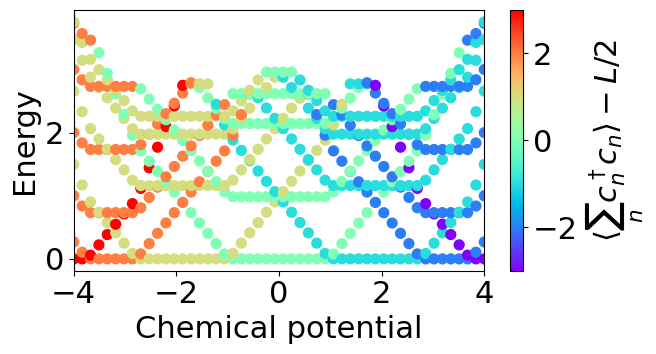

In [11]:

L = 6 # number of sites

def get_energies_den(mu):
    """Return excitation energies"""
    fc = fermionchain.Fermionic_Chain(L) # create the fermion chain object
    H = 0 # initialize Hamiltonian
    for i in range(L-1): # nearest neighbor hopping
        H = H + fc.Cdag[i]*fc.C[i+1] # add hopping
#    for i in range(L-2): H = H + 0.6*fc.Cdag[i]*fc.C[i+2] # second neighbor hopping
    H = H + H.get_dagger() # Hermitian conjugate
    V = 2.0 # interaction
    for i in range(L-1): # nearest neighbor interaction
        H = H + V*(fc.N[i]-0.5)*(fc.N[i+1]-0.5) # add interaction
    for i in range(L): H = H + mu*fc.N[i] # chemical potential
    fc.set_hamiltonian(H) # set the Hamiltonian
    es,wfs = fc.get_excited_states(mode="ED",n=10)
    cs = [wf.dot(sum(fc.N)*wf) for wf in wfs] # expectation values
    return es-es[0],np.array(cs) - L/2.

mus = np.linspace(-4,4.,50)

plt.figure(figsize=(7,4))

for mu in mus: # loop over chemical potentials
    es,cs = get_energies_den(mu) # many-body energies for a system of size N
    plt.scatter(es*0 + mu,es,s=50,c=cs,cmap="rainbow",vmin=-L/2,vmax=L/2) # plot the energies

plt.colorbar(label="$\\langle \sum_n c^\\dagger_n c_n \\rangle - L/2 $")
plt.xlabel("Chemical potential") ; plt.ylabel("Energy") ; plt.xlim([min(mus),max(mus)]) ; plt.tight_layout()

### Quiz
- At which values of chemical potential does the ground state change?
- Make the system smaller, what do you observe and why?
- Make the system bigger, what do you observe and why?

## Electronic density as a function of the chemical potential
We will now look at the density as a function of the chemical potential

Text(0, 0.5, 'Chemical potential')

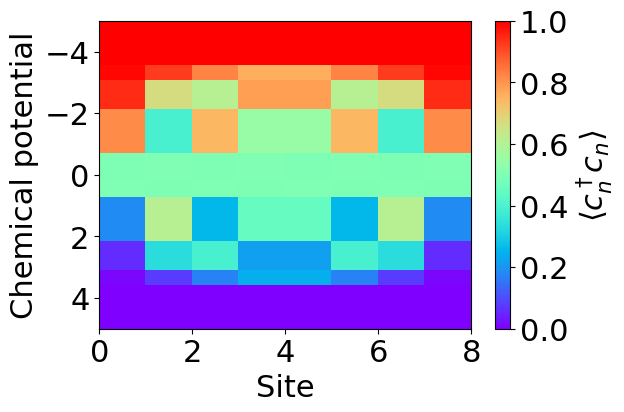

In [12]:
from dmrgpy import spinchain

L = 8 # number of fermionic sites

def get_den(mu):
    """Return excitation energies"""
    fc = fermionchain.Fermionic_Chain(L) # create the fermion chain object
    H = 0 # initialize Hamiltonian
    for i in range(L-1): # nearest neighbor hopping
        H = H + fc.Cdag[i]*fc.C[i+1] # add hopping
#    for i in range(L-2): H = H + 0.6*fc.Cdag[i]*fc.C[i+2] # second neighbor hopping
    H = H + H.get_dagger() # Hermitian conjugate
    V = 2.0 # interaction
    for i in range(L-1): # nearest neighbor interaction
        H = H + V*(fc.N[i]-0.5)*(fc.N[i+1]-0.5) # add interaction
    for i in range(L): H = H + mu*fc.N[i] # chemical potential
    fc.set_hamiltonian(H) # set the Hamiltonian
    wf = fc.get_gs() # gound state
    return [wf.dot(Ni*wf).real for Ni in fc.N] # density in each site



mus = np.linspace(-5.,5.,21,endpoint=True) # chemical potentials
dens = [get_den(mu) for mu in mus] # compute density

plt.figure(figsize=(6,4))

plt.imshow(dens,aspect="auto",extent=[0,L,max(mus),min(mus)],cmap="rainbow")
plt.colorbar(label="$\\langle c^\\dagger_n c_n \\rangle $") ; plt.xlabel("Site") 
plt.ylabel("Chemical potential")

### Quiz
- Why does the density saturate at large chemical potentials?
- Make the system smaller, what do you observe and why?

## Magnetization of an interacting Hubbard model
Here we will now show how the interacting Heisenberg model has zero magnetization

(0.0, 5.0)

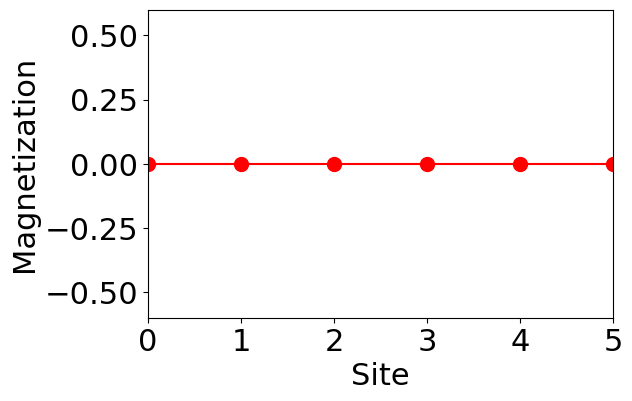

In [13]:
L = 6 # L spinful sites (2*L fermionic sites)
fc = fermionchain.Spinful_Fermionic_Chain(L) # create the fermion chain object

H = 0 # initialize Hamiltonian
for i in range(L-1): # nearest neighbor hopping
    H = H + fc.Cdagup[i]*fc.Cup[i+1] # add hopping
    H = H + fc.Cdagdn[i]*fc.Cdn[i+1] # add hopping
H = H + H.get_dagger() # Hermitian conjugate

U = 6.0 # interaction
for i in range(L): # onsite interaction
    H = H + U*(fc.Nup[i]-0.5)*(fc.Ndn[i]-0.5) # add interaction
mu = 0. # no chemical potential
for i in range(L): H = H + mu*fc.N[i] # chemical potential

Bz = 0. # local magnetic field in the first site
H = H + Bz*fc.Sz[0] # local magnetic field in a site
    
fc.set_hamiltonian(H) # set the Hamiltonian
wf = fc.get_gs(mode="ED") # ground state

iis = range(L) # indexes
cs = [wf.dot(Szi*wf) for Szi in fc.Sz] # compute the vacuum expectation value

plt.figure(figsize=(6,4))

plt.plot(iis,cs,marker="o",c="red",markersize=10)
plt.xlabel("Site") ; plt.ylabel("Magnetization") ; plt.ylim([-0.6,0.6]) ; plt.xlim([min(iis),max(iis)])

### Quiz
- Why is the magnetization zero everywhere even though there is a large electronic interaction?
- Add a small magnetic field in the first site, what do you observe?
- Keep the magnetic field and remove the interactions, what do you observe, and why?

## Magnetization of a Hubbard model with stagger magnetization
We will now see how the Hubbard model can be driven to its classical mean-field solution

Text(0, 0.5, '$J_{AF}$')

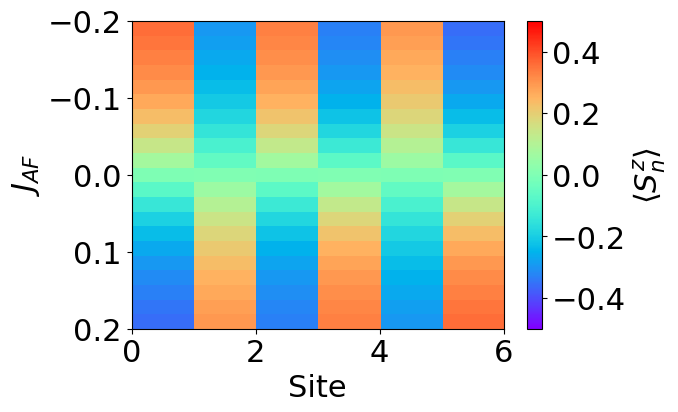

In [4]:
L = 6 # number of sites

def get_mz(Jaf):
    fc = fermionchain.Spinful_Fermionic_Chain(L) # create the fermion chain object
    H = 0 # initialize Hamiltonian
    for i in range(L-1): # nearest neighbor hopping
        H = H + fc.Cdagup[i]*fc.Cup[i+1] # add hopping
        H = H + fc.Cdagdn[i]*fc.Cdn[i+1] # add hopping
    H = H + H.get_dagger() # Hermitian conjugate
    U = 6.0 # interaction
    for i in range(L): # onsite interaction
        H = H + U*(fc.Nup[i]-0.5)*(fc.Ndn[i]-0.5) # add interaction
    for i in range(L): H = H + (-1)**i*Jaf*fc.Sz[i] # add AF exchange
    fc.set_hamiltonian(H)
    wf0 = fc.get_gs()
    return [wf0.dot(Szi*wf0).real for Szi in fc.Sz] # magnetization in each site



Jafs = np.linspace(-0.2,0.2,21,endpoint=True) # exchange fields
Mzs = [get_mz(Jaf) for Jaf in Jafs] # compute magnetizations

plt.figure(figsize=(6,4))

plt.imshow(Mzs,aspect="auto",extent=[0,L,max(Jafs),min(Jafs)],vmin=-0.5,vmax=0.5,cmap="rainbow")
plt.colorbar(label="$\\langle S^z_n \\rangle $") ; plt.xlabel("Site") ; plt.ylabel("$J_{AF}$")

### Quiz
- Why is the magnetization zero for B=0?
- Increase the value of U, does the magnetization saturate sooner or later, and why?

## Connection between the Hubbard and Heisenberg models
We will here see how a Hubbard model at half filling behaves as a Heisenberg model

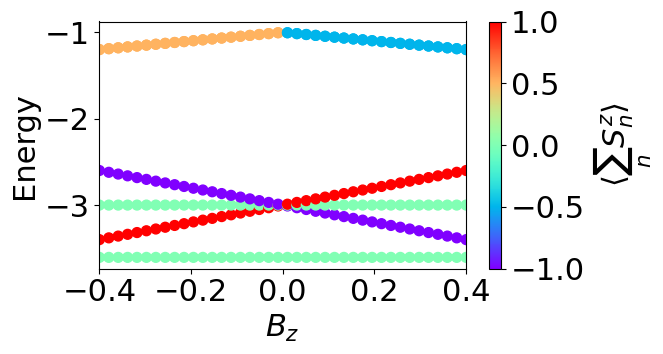

In [5]:
from dmrgpy import spinchain

def get_energies(Bz=0.,U=4):
    L = 2 # number of sites
    fc = fermionchain.Spinful_Fermionic_Chain(L) # create the fermion chain object
    H = 0 # initialize Hamiltonian
    for i in range(L-1): # nearest neighbor hopping
        H = H + fc.Cdagup[i]*fc.Cup[i+1] # add hopping
        H = H + fc.Cdagdn[i]*fc.Cdn[i+1] # add hopping
    H = H + H.get_dagger() # Hermitian conjugate

    for i in range(L): # onsite interaction
        H = H + U*(fc.Nup[i]-0.5)*(fc.Ndn[i]-0.5) # add interaction
    H = H + Bz*(sum(fc.Sz)) # magnetic field
    fc.set_hamiltonian(H) # set the Hamiltonian
    es,wfs = fc.get_excited_states(n=6,mode="ED") # get excited state energies
    mzs = [wf.dot(sum(fc.Sz)*wf).real for wf in wfs] # expectation value
    return es,mzs

Ls = range(2,8,2) # lengths of the system to consider

Bzs = np.linspace(-0.4,0.4,40)
plt.figure(figsize=(7,4))

for Bz in Bzs: # loop over magnetic fields
    es,cs = get_energies(Bz,U=6) # many-body energies for a system of size N
    plt.scatter(es*0 + Bz,es,s=50,c=cs,cmap="rainbow",vmin=-1,vmax=1) # plot the energies

plt.colorbar(label="$\\langle \sum_n S^z_n \\rangle $")
plt.xlabel("$B_z$") ; plt.ylabel("Energy") ; plt.xlim([min(Bzs),max(Bzs)]) ; plt.tight_layout()

### Quiz
- Which states can be mapped to a Heisenberg model?
- Increase the value of U, what happens and why?
- Decrease the value of U, what happens and why?

## Gap of an interacting Hubbard model
We will now see how the gap for a many-body spin chain scales with the system size, both for a pristine Heisenberg model and a dimerized one

(2.0, 6.0)

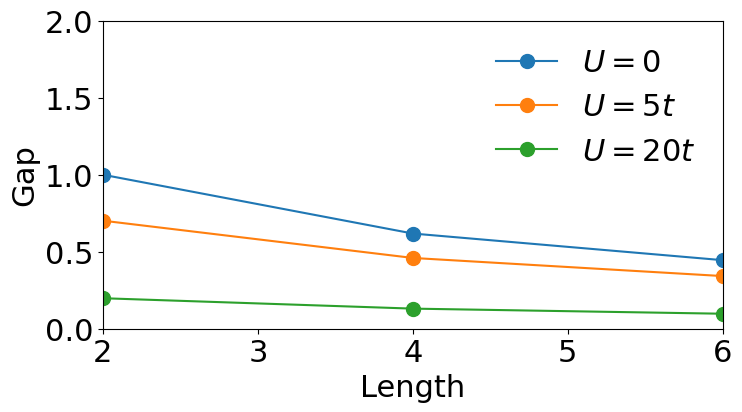

In [6]:
from dmrgpy import spinchain

def get_gap(L=6,U=0.):
    fc = fermionchain.Spinful_Fermionic_Chain(L) # create the fermion chain object
    H = 0 # initialize Hamiltonian
    for i in range(L-1): # nearest neighbor hopping
        H = H + fc.Cdagup[i]*fc.Cup[i+1] # add hopping
        H = H + fc.Cdagdn[i]*fc.Cdn[i+1] # add hopping
    H = H + H.get_dagger() # Hermitian conjugate

    for i in range(L): # onsite interaction
        H = H + U*(fc.Nup[i]-0.5)*(fc.Ndn[i]-0.5) # add interaction
    fc.set_hamiltonian(H) # set the Hamiltonian
    es = fc.get_excited(n=2,mode="ED") # get excited state energies
    g = es[1]-es[0] # energy to the first excited state
    return g # return the many-body gap

Ls = range(2,8,2) # lengths of the system to consider
gaps = [get_gap(L=L,U=0.) for L in Ls] # non-interacting
gaps_U5 = [get_gap(L=L,U=5) for L in Ls] # strongly-interacting
gaps_U20 = [get_gap(L=L,U=20) for L in Ls] # strongly-interacting

plt.figure(figsize=(8,4))
plt.plot(Ls,gaps,label="$U = 0$",marker="o",markersize=10)
plt.plot(Ls,gaps_U5,label="$U = 5t$",marker="o",markersize=10)
plt.plot(Ls,gaps_U20,label="$U = 20t$",marker="o",markersize=10)
plt.legend(frameon=False)
plt.xlabel("Length") ; plt.ylabel("Gap") ; plt.ylim([0.,2.0]) ; plt.xlim([2,max(Ls)])

### Quiz
- Why is the many-body gap decreasing with increasing U?
- What is the lowest energy excitation of the system for large U?

## Non-local static correlators for the spin response
We will now see how the non-local static correlators how is the spin response of a system

Text(0, 0.5, '$\\langle S_0^x S_N^x \\rangle $')

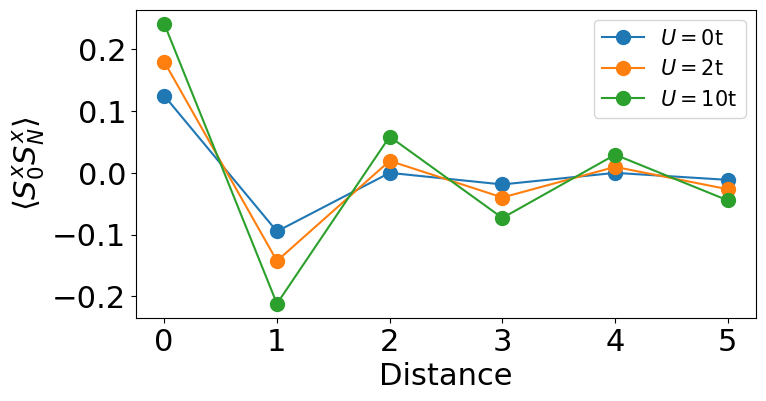

In [7]:
def get_correlator(U=0.):
    L = 6 # number of sites
    fc = fermionchain.Spinful_Fermionic_Chain(L) # create the fermion chain object
    H = 0 # initialize Hamiltonian
    for i in range(L-1): # nearest neighbor hopping
        H = H + fc.Cdagup[i]*fc.Cup[i+1] # add hopping
        H = H + fc.Cdagdn[i]*fc.Cdn[i+1] # add hopping
    H = H + H.get_dagger() # Hermitian conjugate

    for i in range(L): # onsite interaction
        H = H + U*(fc.Nup[i]-0.5)*(fc.Ndn[i]-0.5) # add interaction

    fc.set_hamiltonian(H) # set the Hamiltonian
    wf0 = fc.get_gs(mode="ED") # get ground state
    return [wf0.dot((fc.Sx[0]*fc.Sx[i])*wf0).real for i in range(L)]

plt.figure(figsize=(8,4))

Us = [0,2,10] # interactions
for U in Us:
    cij = get_correlator(U=U)
    plt.plot(range(len(cij)),cij,label="$U =$"+str(U)+"t",marker="o",markersize=10)

plt.legend(fontsize=15)
plt.xlabel("Distance") ; plt.ylabel("$\\langle S_0^x S_N^x \\rangle $") #; plt.ylim([0.,2.0]) ; plt.xlim([2,max(Ls)])

### Quiz
- Which system is more susceptible to magnetic ordering?
- Use attractive interactions instead of repulsive, what do you observe and why?
- Compute the ZZ correlator instead of XX, what do you observe, and why?

## Non-local static correlators for the particle-particle response
We will now see how the non-local static correlators hof the particle-particle response to see how the system becomes insulating

Text(0, 0.5, '$\\langle c^{\\dagger}_{0\\uparrow} c_{N\\uparrow} \\rangle $')

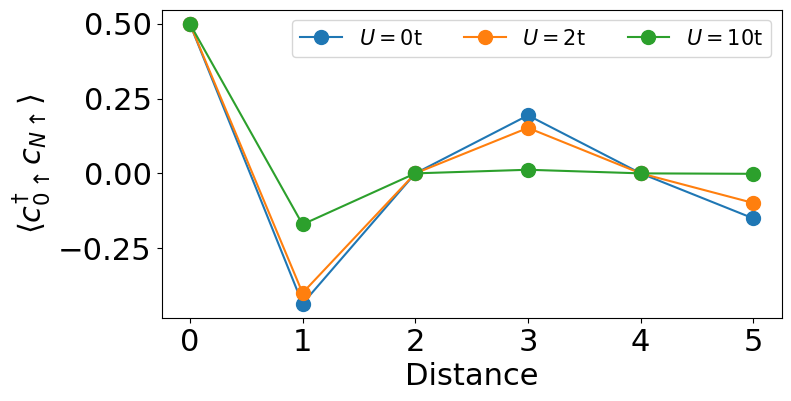

In [8]:
def get_correlator(U=0.):
    L = 6 # number of sites
    fc = fermionchain.Spinful_Fermionic_Chain(L) # create the fermion chain object
    H = 0 # initialize Hamiltonian
    for i in range(L-1): # nearest neighbor hopping
        H = H + fc.Cdagup[i]*fc.Cup[i+1] # add hopping
        H = H + fc.Cdagdn[i]*fc.Cdn[i+1] # add hopping
    H = H + H.get_dagger() # Hermitian conjugate

    for i in range(L): # onsite interaction
        H = H + U*(fc.Nup[i]-0.5)*(fc.Ndn[i]-0.5) # add interaction

    fc.set_hamiltonian(H) # set the Hamiltonian
    wf0 = fc.get_gs(mode="ED") # get ground state
    return [wf0.dot((fc.Cdagup[0]*fc.Cup[i])*wf0).real for i in range(L)]

plt.figure(figsize=(8,4))

Us = [0,2,10] # interactions
for U in Us:
    cij = get_correlator(U=U)
    plt.plot(range(len(cij)),cij,label="$U =$"+str(U)+"t",marker="o",markersize=10)

plt.legend(ncol=len(Us),fontsize=15)
plt.xlabel("Distance") ; plt.ylabel("$\\langle c^{\\dagger}_{0\\uparrow} c_{N\\uparrow} \\rangle $") #; plt.ylim([0.,2.0]) ; plt.xlim([2,max(Ls)])

### Quiz
- Which system is an insulator for single charge excitations?
- Use attractive interactions instead of repulsive, what do you observe and why?
- Compute the down-down correlator instead of up up, what do you observe, and why?

## Dynamical particle-particle correlators in the Hubbard model
Let us now look at the dynamical correlator of a Hubbard model

Text(0, 0.5, '$Energy$')

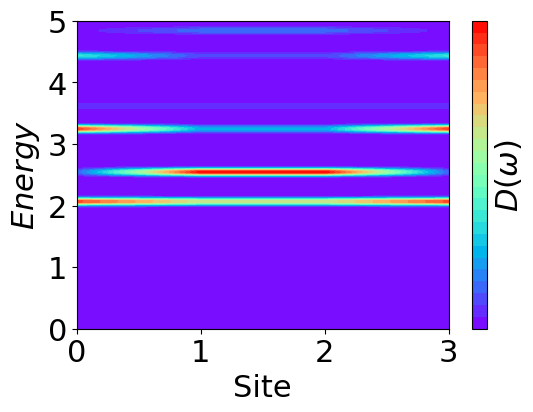

In [12]:
L = 4 # number of sites
fc = fermionchain.Spinful_Fermionic_Chain(L) # create the fermion chain object
H = 0 # initialize Hamiltonian
for i in range(L-1): # nearest neighbor hopping
    H = H + fc.Cdagup[i]*fc.Cup[i+1] # add hopping
    H = H + fc.Cdagdn[i]*fc.Cdn[i+1] # add hopping
H = H + H.get_dagger() # Hermitian conjugate
U = 6.0 # interaction
for i in range(L): # onsite interaction
    H = H + U*(fc.Nup[i]-0.5)*(fc.Ndn[i]-0.5) # add interaction

fc.set_hamiltonian(H) # set the Hamiltonian

es = np.linspace(-0.,5,300) # energies
dyn = [fc.get_dynamical_correlator(name=(fc.Cdagup[i],fc.Cup[i]),mode="ED",es=es)[1].real for i in range(L)]

plt.figure(figsize=(6,4))
plt.contourf(range(L),es,np.array(dyn).T,aspect="auto",levels=30,cmap="rainbow")
plt.colorbar(label="$D(\omega)$",ticks=[]) ; plt.xlabel("Site") ; plt.ylabel("$Energy$") 

### Quiz
- Increase the value of U, what happens and why?
- Decrease the value of U, what happens and why?
- What is the physical meaning of this excitations?

## Dynamical spin-spin correlators in the Hubbard model
Let us now look at the dynamical spin-spin correlator of a Hubbard model

Text(0, 0.5, '$Energy$')

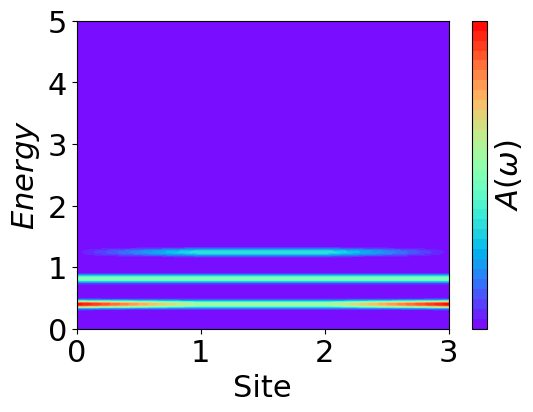

In [13]:
L = 4 # number of sites
fc = fermionchain.Spinful_Fermionic_Chain(L) # create the fermion chain object
H = 0 # initialize Hamiltonian
for i in range(L-1): # nearest neighbor hopping
    H = H + fc.Cdagup[i]*fc.Cup[i+1] # add hopping
    H = H + fc.Cdagdn[i]*fc.Cdn[i+1] # add hopping
H = H + H.get_dagger() # Hermitian conjugate
U = 6.0 # interaction
for i in range(L): # onsite interaction
    H = H + U*(fc.Nup[i]-0.5)*(fc.Ndn[i]-0.5) # add interaction

fc.set_hamiltonian(H) # set the Hamiltonian

es = np.linspace(-0.,5,300) # energies
dyn = [fc.get_dynamical_correlator(name=(fc.Sz[i],fc.Sz[i]),mode="ED",es=es)[1].real for i in range(L)]

plt.figure(figsize=(6,4))
plt.contourf(range(L),es,np.array(dyn).T,aspect="auto",levels=30,cmap="rainbow")
plt.colorbar(label="$A(\omega)$",ticks=[]) ; plt.xlabel("Site") ; plt.ylabel("$Energy$") 

### Quiz
- Increase the value of U, what happens and why?
- Decrease the value of U, what happens and why?
- What is the physical meaning of these excitations?

## Interaction dependence of the dynamical excitations in the Hubbard model
Let us now check systematically what is the dependence of the many-body excitations of a Hubbard dimer

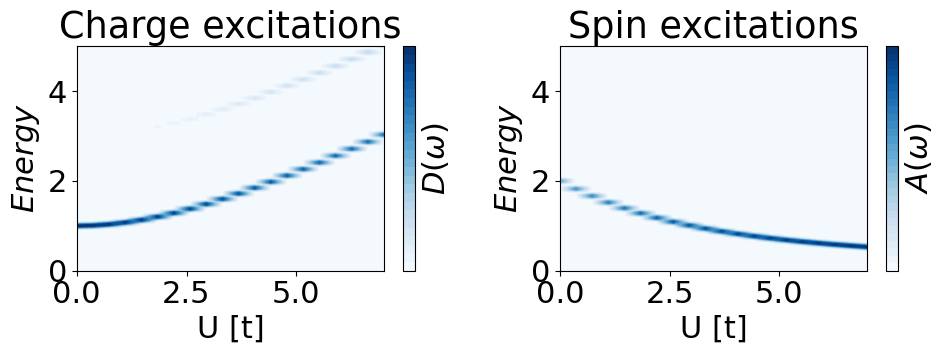

In [14]:
es = np.linspace(-0.,5,300) # energies
L = 2 # number of sites
fc = fermionchain.Spinful_Fermionic_Chain(L) # create the fermion chain object

def get_dyn_corr(U=4.,Op=fc.Cdagup[0]):
    H = 0 # initialize Hamiltonian
    for i in range(L-1): # nearest neighbor hopping
        H = H + fc.Cdagup[i]*fc.Cup[i+1] # add hopping
        H = H + fc.Cdagdn[i]*fc.Cdn[i+1] # add hopping
    H = H + H.get_dagger() # Hermitian conjugate
    for i in range(L): # onsite interaction
        H = H + U*(fc.Nup[i]-0.5)*(fc.Ndn[i]-0.5) # add interaction
    Bx = 0. # magnetic field
    H = H + Bx*sum(fc.Sx) # magnetic field
    fc.set_hamiltonian(H) # set the Hamiltonian
    return fc.get_dynamical_correlator(name=(Op.get_dagger(),Op),mode="ED",es=es)[1]
        

fc.set_hamiltonian(H) # set the Hamiltonian

Us = np.linspace(0.,7.,20)
dyn_p = [get_dyn_corr(U=U,Op=fc.Cdagup[0]) for U in Us] # particle-particle correlator
dyn_sz = [get_dyn_corr(U=U,Op=fc.Sz[0]) for U in Us] # particle-particle correlator


plt.figure(figsize=(10,4))

plt.subplot(1,2,1) ; plt.title("Charge excitations")
plt.contourf(Us,es,np.array(dyn_p).T,aspect="auto",levels=30,cmap="Blues")
plt.colorbar(label="$D(\omega)$",ticks=[]) ; plt.xlabel("U [t]") ; plt.ylabel("$Energy$") 

plt.subplot(1,2,2) ; plt.title("Spin excitations")
plt.contourf(Us,es,np.array(dyn_sz).T,aspect="auto",levels=30,cmap="Blues")
plt.colorbar(label="$A(\omega)$",ticks=[]) ; plt.xlabel("U [t]") ; plt.ylabel("$Energy$") 

plt.tight_layout()

### Quiz
- Why do the charge excitations increase in energy with U?
- Why do the spin excitations decrease in energy with U?
- Make the system bigger, what do you observe and why?
- Add a magnetic field, what do you observe and why?